# **Modelling and Evaluation - Predict Default (Classification)**

## Objectives

*   Fit and evaluate a classification model to predict if a debt applicant will default or not.
*   Answer **business requirement 2**: 
    * The client is interested in creating a classification model able to predict loan applicant default event with high confidence with high precision of at least 85%. 

## Inputs

* outputs/datasets/collection/row/LoanDefaultDataset.csv
* Instructions on which variables to use for data cleaning and feature engineering. Those instructions are found in FeatureEngineering Notebook.

## Outputs

* The following is a list of files to be saved in the output folder:

  - Train Set
  - Test Set
  - Modeling pipeline
  - label map
  - feature importance plot

---

## **SetUp**

### Change working directory

* Change the working directory from its current folder to its parent folder.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/loan_default/jupyter_notebooks'

* Make the parent of the current directory the new current directory.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


* Confirm the new current directory.

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/loan_default'

## **Dataset Loading**

- Load the row dataset.

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/row/LoanDefaultDataset.csv"))
df.head(3)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1


## **ML Pipeline with All Features**

### **Split Train and Test Set**

- Split the row dataset into Train and Test.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['loan_status'], axis=1),
    df['loan_status'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36000, 13) (36000,) (9000, 13) (9000,)


### **Data Cleaning and Feature Engineering Pipeline**

#### Data Cleaning

- Since the data is already clean, this step is skipped.

#### Feature Engineering Pipeline

- The feature engineering pipeline is extracted from **Notebook 03**.

In [6]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt


def PipelineFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=[
                                                        'person_gender',
                                                        'person_education',
                                                        'person_home_ownership',
                                                        'loan_intent',
                                                        'previous_loan_defaults_on_file',
                                                        ])),
        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
            variables = [
                'person_income',
                'loan_amnt',
                'loan_percent_income',
                'credit_score',
                ])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.7, selection_method="variance")), # to be dropped = ['person_age', 'cb_person_cred_hist_length'].
    ])

    return pipeline_base


PipelineFeatureEngineering()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_gender', 'person_education',
                                           'person_home_ownership',
                                           'loan_intent',
                                           'previous_loan_defaults_on_file'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['person_income', 'loan_amnt',
                                                  'loan_percent_income',
                                                  'credit_score'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.7))])

- Apply Feature Engineering Pipeline.

In [7]:
pipeline_feat_eng = PipelineFeatureEngineering()
X_train = pipeline_feat_eng.fit_transform(X_train)
X_test = pipeline_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36000, 11) (36000,) (9000, 11) (9000,)


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]


### **Target Balance Analysis**

- Display Train Set Target (loan_status) distribution.
- Evaluate if the two loan_status classes (Default = 0, No Default = 1) are balanced.

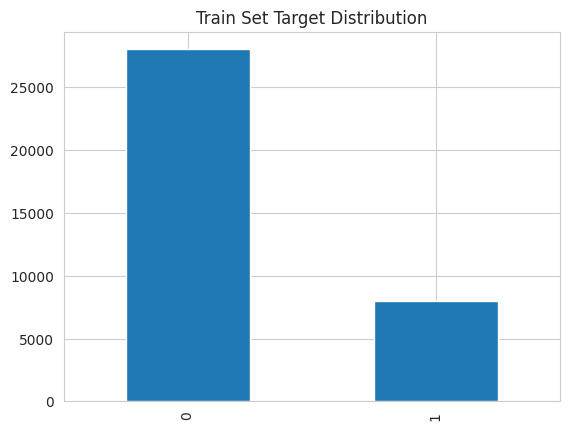

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

> Result:

- The default class (0) has more occurrences, hence the train set ought to be balanced.
- In order to balance both classes in the Train Set, SMOTE (Synthetic Minority Oversampling TEchnique) is used. 
- This is accomplished by oversampling the minority class (No Default = 1).

- Apply **SMOTE (Synthetic Minority Oversampling TEchnique)**.

In [9]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(55978, 11) (55978,) (9000, 11) (9000,)


- Evaluate the Train Set Target distribution after oversampling.

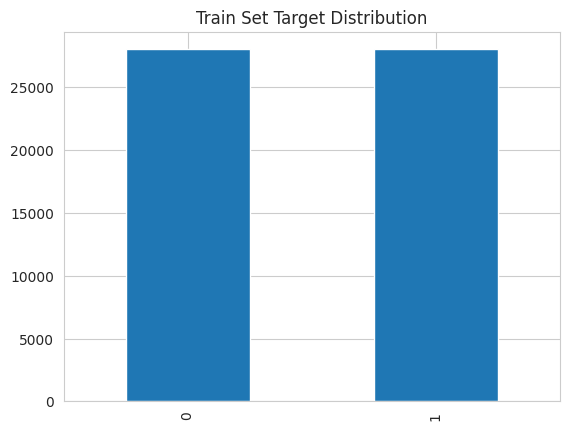

In [10]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### **ML Pipeline**

#### Define the main functions and Dictionaries for creating the pipeline.

- Classification Pipeline.

In [11]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


-  Hyperparameter Optimization Class.

In [12]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

* Define a dictionary for estimators with standard hyperparameters.

In [13]:
models_quick_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}

params_quick_search = {
    "RandomForestClassifier": {},
}

#### Grid Search CV

##### Estimator Search

- Evaluate estimators performance scores.

In [14]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=0),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


* Summarize estimators performance scores result.
* Display the scores' results in a table.

In [15]:
import numpy as np


grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,RandomForestClassifier,0.900679,0.911572,0.938371,0.014401


* Display the best Estimator.

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

> Result:

* The best performing estimators are list below by order:
  * **ExtraTreesClassifier** with mean score of **0.922684**
  * **DecisionTreeClassifier** with mean score of **0.913751**
  * **RandomForestClassifier** with mean score of **0.911715**
* **Important Note**:
  * when implementing **ExtraTreesClassifier** pipeline_clf pickle file becomes exterimly large (> 100 MB, which is not compatible with GitHub max storage). Therefore, the **RandomForestClassifier** is used as an Alternative. 
* The next step aims to search for the hyperparameter configurations seeking better estimator scores.

##### Search Hyperparameter Configurations

* Define a dictionary for the best three estimator: **ExtraTreesClassifier**, **DecisionTreeClassifier** and **RandomForestClassifier**.
* Define a dictionary for candidate hyperparameter configurations of each nominated estimator.

In [17]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}
params_search = {
    "RandomForestClassifier":{'model__n_estimators': [100,50,140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
                            },
  }

* Apply HyperparameterOptimizationSearch on candidate estimators with the candidate parameter configurations.

In [20]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


* Summarize the configurations score.

In [21]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,RandomForestClassifier,0.799214,0.921364,0.968739,0.064365


* Display the best hyperparameters configuration for **ExtraTreesClassifier**.

In [22]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{}

> Result:
- The estimator performance improves by optimizing the hyperparameter.
- The mean score with optimized hyperparameter is 0.911822. No significant improvement over the default configuration.
- best_parameters = `{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}`.

* Define the best clf pipeline.

In [23]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model', RandomForestClassifier(random_state=0))])

### Pipeline Evaluation

In [24]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

> **Business Requirement 2**:
  - Default event should be predicted with high confidence, specifically, at least 85% precision.

- Display Confusion Matrix.

In [25]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Default','No Default']
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual Default Actual No Default
Prediction Default             27988                 0
Prediction No Default              1             27989


---  Classification Report  ---
              precision    recall  f1-score   support

     Default       1.00      1.00      1.00     27989
  No Default       1.00      1.00      1.00     27989

    accuracy                           1.00     55978
   macro avg       1.00      1.00      1.00     55978
weighted avg       1.00      1.00      1.00     55978
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual Default Actual No Default
Prediction Default              6403               303
Prediction No Default            608              1686


---  Classification Report  ---
              precision    recall  f1-score   support

     Default       0.95      0.91      0.93      7011
  No Default       0.73      0.85      0.79      1989

    accuracy 

> Result:

* for test set:

  - Default Precision: 0.95
  - Default Recall: 0.91
  - No Default Precision: 0.74
  - No Default Recall: 0.85

### **Assess feature importance**

- Extract the important features.

* These are the 4 most important features in descending order. The model was trained on them: 
['previous_loan_defaults_on_file', 'loan_percent_income', 'loan_int_rate', 'person_income']


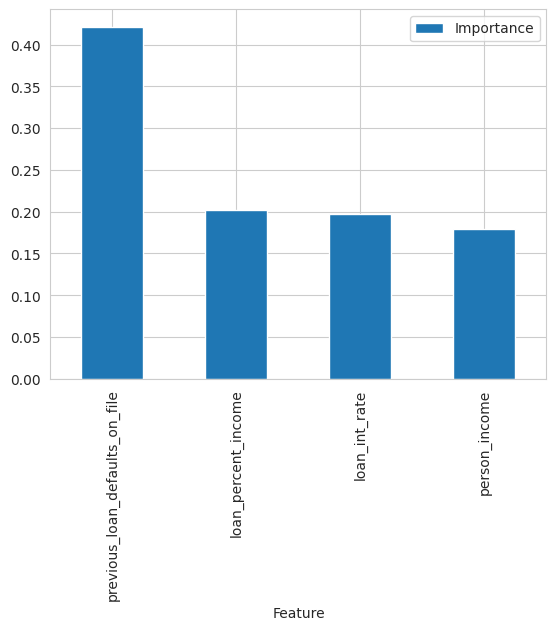

In [26]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

> Result:
- best_features = `['previous_loan_defaults_on_file', 'loan_percent_income', 'loan_int_rate', 'person_income']`.

> Summary of **ML Pipeline with All Features**:

- * **RandomForestClassifier** proved to be the most effective estimator which also produces smaller clf_pipeline pickle file in comparsion with other two candidates. The estimator is defined with a configuration: `{'model__max_depth': None,
 'model__max_leaf_nodes': [None],
 'model__min_samples_leaf': [1],
 'model__min_samples_split': [2],
 'model__n_estimators': [140]
}`.
* The model performs extremely well on the full features pipeline both on the train and test dataset.
* The model suffices the business requirement 2 with higher precision than what business stipulates.
* An assessment is conducted to identify the most important features.
* Three features are assessed to be important. These are: `['previous_loan_defaults_on_file', 'loan_percent_income', 'loan_int_rate', 'person_income']`.
* The next step is to evaluate the ML pipeline on the most important features only.

## **ML Pipeline with Important Features**

- Display Best Features.

In [27]:
best_features

['previous_loan_defaults_on_file',
 'loan_percent_income',
 'loan_int_rate',
 'person_income']

> Result:
- best_features = `['previous_loan_defaults_on_file',
 'loan_percent_income',
 'loan_int_rate',
 'person_income']`.

### **Split Train and Test Set**

- Split the row dataset into Train and Test.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['loan_status'], axis=1),
    df['loan_status'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36000, 13) (36000,) (9000, 13) (9000,)


- Consider only the best features.

In [29]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(36000, 4) (36000,) (9000, 4) (9000,)


,previous_loan_defaults_on_file,loan_percent_income,loan_int_rate,person_income
39676,Yes,0.01,7.46,93802.0
13676,Yes,0.17,14.11,77584.0
10718,No,0.21,11.71,48618.0


### **Data Cleaning and Feature Engineering Pipeline**

#### Data Cleaning

- Since the data is already clean, this step is skipped.

#### Feature Engineering Pipeline

- The feature engineering pipeline is extracted from **Notebook 03** with employing the best features instead.
- Since the dataset now does not contain the to-be-dropped features ['person_age', 'cb_person_cred_hist_length'], SmartCorrelatedSelection is dropped from the pipeline.

In [30]:
def PipelineFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=[
                                                        'previous_loan_defaults_on_file',
                                                        ])),
        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
            variables = ['loan_percent_income','person_income',]
            )),
        # SmartCorrelatedSelection is removed since we filter out all the unneeded features
        # by only selecting the important features.
    ])

    return pipeline_base

PipelineFeatureEngineering()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['previous_loan_defaults_on_file'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['loan_percent_income',
                                                  'person_income']))])

In [31]:
X_train.head(3)

,previous_loan_defaults_on_file,loan_percent_income,loan_int_rate,person_income
39676,Yes,0.01,7.46,93802.0
13676,Yes,0.17,14.11,77584.0
10718,No,0.21,11.71,48618.0


- Apply Data Feature Engineering Pipeline.

In [32]:
pipeline_feat_eng = PipelineFeatureEngineering()
X_train = pipeline_feat_eng.fit_transform(X_train)
X_test =pipeline_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36000, 4) (36000,) (9000, 4) (9000,)


### **Target Balance Analysis**

- Display Train Set Target (loan_status) distribution.
- Evaluate if the two loan_status classes (Default = 0, No Default = 1) are balanced.

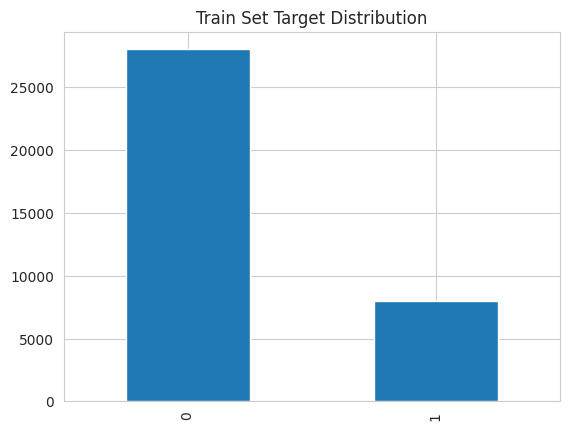

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

> Result:

- The default class (0) has more occurrences, hence the train set ought to be balanced.
- In order to balance both classes in the Train Set, SMOTE (Synthetic Minority Oversampling TEchnique) is used. 
- This is accomplished by oversampling the minority class (No Default = 1).

- Apply **SMOTE (Synthetic Minority Oversampling TEchnique)**.

In [34]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(55978, 4) (55978,) (9000, 4) (9000,)


- Evaluate the Train Set Target distribution after oversampling.

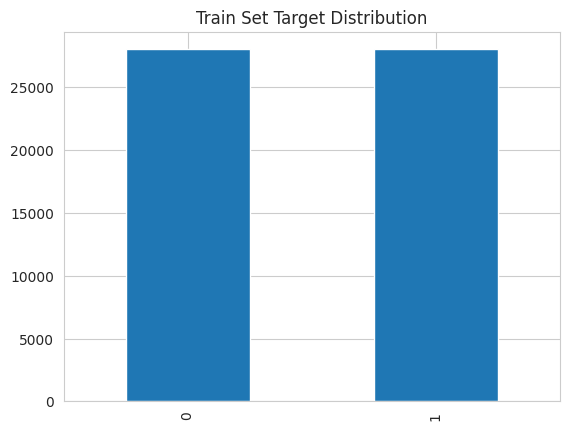

In [35]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### **Model Pipeline**

- Classification Pipeline.

In [36]:
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
    ])

    return pipeline_base

#### Grid Search CV

- The best model and its hyperparameter configuration extracted from the earlier task are:
  - Estimator : **RandomForestClassifier**.
  - Hyperparameter Configuration: `{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}`.

In [37]:
models_search # RandomForestClassifier

{'RandomForestClassifier': RandomForestClassifier(random_state=0)}

In [38]:
best_model = {'RandomForestClassifier': RandomForestClassifier(random_state=0)}

- Display the best hyperparameter configurations.

In [39]:
best_parameters

{}

- Define a new search parameters based on the best configurations identified in the earlier step.

In [40]:
params_search = {'RandomForestClassifier': {
    'model__max_depth': [None],
    'model__max_leaf_nodes': [None],
    'model__min_samples_leaf': [1],
    'model__min_samples_split': [2],
    'model__n_estimators': [140]
},
}
params_search

{'RandomForestClassifier': {'model__max_depth': [None],
  'model__max_leaf_nodes': [None],
  'model__min_samples_leaf': [1],
  'model__min_samples_split': [2],
  'model__n_estimators': [140]}}

- Apply the the Search.

In [41]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=best_model, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=0),
                 n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


- Display the algorithm score result

In [42]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.912469,0.920111,0.932655,0.007066,None,None,1,2,140


> Note:
- The estimator performance is slightly better after refitting the model on the significant features. 
- The mean score with all the features is 0.911.
- The mean score with the significant features is 0.915967.

- Display the best model.

In [43]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'RandomForestClassifier'

- Display the best parameter.

In [44]:
best_parameters = {'model__max_depth': [None],
 'model__max_leaf_nodes': [None],
 'model__min_samples_leaf': [1],
 'model__min_samples_split': [2],
 'model__n_estimators': [140]}
best_parameters

{'model__max_depth': [None],
 'model__max_leaf_nodes': [None],
 'model__min_samples_leaf': [1],
 'model__min_samples_split': [2],
 'model__n_estimators': [140]}

- Define and then display the best clf pipline.

In [45]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(n_estimators=140, random_state=0))])

#### Evaluate Pipeline on Train and Test Sets

In [46]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Default', 'No Default'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual Default Actual No Default
Prediction Default             27989                 0
Prediction No Default              0             27989


---  Classification Report  ---
              precision    recall  f1-score   support

     Default       1.00      1.00      1.00     27989
  No Default       1.00      1.00      1.00     27989

    accuracy                           1.00     55978
   macro avg       1.00      1.00      1.00     55978
weighted avg       1.00      1.00      1.00     55978
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual Default Actual No Default
Prediction Default              6454               329
Prediction No Default            557              1660


---  Classification Report  ---
              precision    recall  f1-score   support

     Default       0.95      0.92      0.94      7011
  No Default       0.75      0.83      0.79      1989

    accuracy 

> Result:

* for test set:

  - Default Precision: 0.95
  - Default Recall: 0.92
  - No Default Precision: 0.75
  - No Default Recall: 0.83

> Summary of **ML Pipeline with Best Features**:

* **RandomForestClassifier** proved to be the most effective estimator with a configuration: `{'model__max_depth': [None],
 'model__max_leaf_nodes': [None],
 'model__min_samples_leaf': [1],
 'model__min_samples_split': [2],
 'model__n_estimators': [140]}`.
* The model performance sustain it performance on the important feature pipeline with even a slight improvement.
* The model suffices the business requirement 2 with higher precision than what business stipulates.
* Three features are assessed to be important. These are: best_features = `['previous_loan_defaults_on_file', 'loan_percent_income', 'loan_int_rate', 'person_income']`.

### **Assess feature importance**

- Extract the important features.

* These are the 4 most important features in descending order. The model was trained on them: 
['previous_loan_defaults_on_file', 'loan_percent_income', 'loan_int_rate', 'person_income']


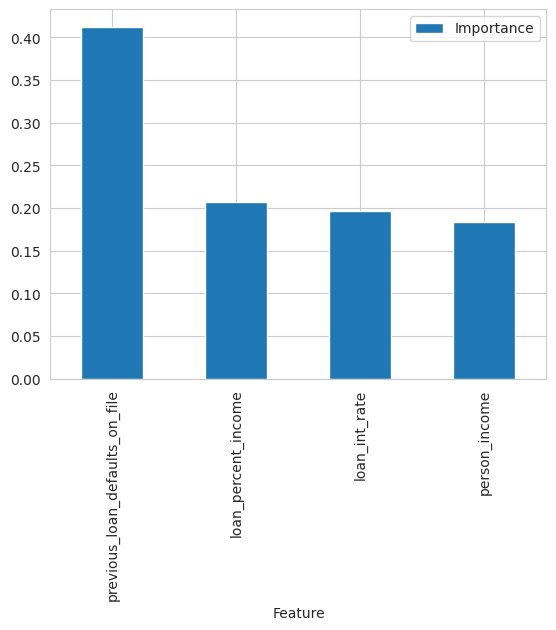

In [47]:
best_features = X_train.columns

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)


# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

> Result:
- The result affirms that are no additional filtration has occurred to the input features of the pipeline.
- best_features = `['previous_loan_defaults_on_file', 'loan_percent_income', 'loan_int_rate', 'person_income']`.

## **Push files to Repo**

- The following list summarize the Notebook's generated outputs:
  - Train Set
  - Test Set
  - Modeling pipeline
  - label map
  - feature importance plot

### Output folder

In [48]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_default/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

### Data sets

#### Train Set

- Display the train set (features).

In [49]:
X_train.head(3)

,previous_loan_defaults_on_file,loan_percent_income,loan_int_rate,person_income
0,0,0.009725,7.46,7.194033
1,0,0.111589,14.11,7.124611
2,1,0.126641,11.71,6.948628


- Save the train set (features).

In [50]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

- Display the train set (target='loan_status').

In [51]:
y_train.head(3)

0    0
1    0
2    0
Name: loan_status, dtype: int64

- Save the train set (target='loan_status').

In [52]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set

- Display the Test set (features).

In [53]:
X_test.head(3)

,previous_loan_defaults_on_file,loan_percent_income,loan_int_rate,person_income
44885,1,0.158333,10.84,7.100598
10988,1,0.107355,14.74,7.160275
26912,1,0.051072,11.01,7.346985


- Save the Test set (features).

In [54]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

- Display the Test set (target='loan_status').

In [55]:
y_test.head(3)

44885    1
10988    0
26912    0
Name: loan_status, dtype: int64

- Save the Test set (target='loan_status').

In [56]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Data Cleaning and Feature Engineering

> Note:

- Since the row data is already cleaned there is no data clean pipeline to be saved or incorporated into the feature engineering pipeline.

- Display the Feature Engineering Pipeline.

In [57]:
pipeline_feat_eng

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['previous_loan_defaults_on_file'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['loan_percent_income',
                                                  'person_income']))])

- Save the Feature Engineering Pipeline.

In [58]:
joblib.dump(value=pipeline_feat_eng ,
            filename=f"{file_path}/clf_pipeline_feat_eng.pkl")

['outputs/ml_pipeline/predict_default/v1/clf_pipeline_feat_eng.pkl']

### Model Pipeline

- Display Feature Scaling and Model pipeline.

In [59]:
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(n_estimators=140, random_state=0))])

- Save the Model Pipeline as a pickle file.

In [60]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/ml_pipeline/predict_default/v1/clf_pipeline_model.pkl']

- Calculate clf_pipeline_model.pkl file size before git commit and push.
- If the file size > 100Mb repeat the search to find the most efficient estimator both in terms of score and model size. 

In [61]:
import os

clf_pipeline_model_file_path = "outputs/ml_pipeline/predict_default/v1/clf_pipeline_model.pkl"
file_size_bytes = os.path.getsize(clf_pipeline_model_file_path)
print("File size in bytes:", file_size_bytes)

file_size_mb = file_size_bytes/(1024 * 1024)
print("File size in MB:", round(file_size_mb, 2))

File size in bytes: 80602751
File size in MB: 76.87


> Result:

File size in MB: 85.4 when using RandomForestClassifier.

### Feature importance plot

- Display feature importance plot.

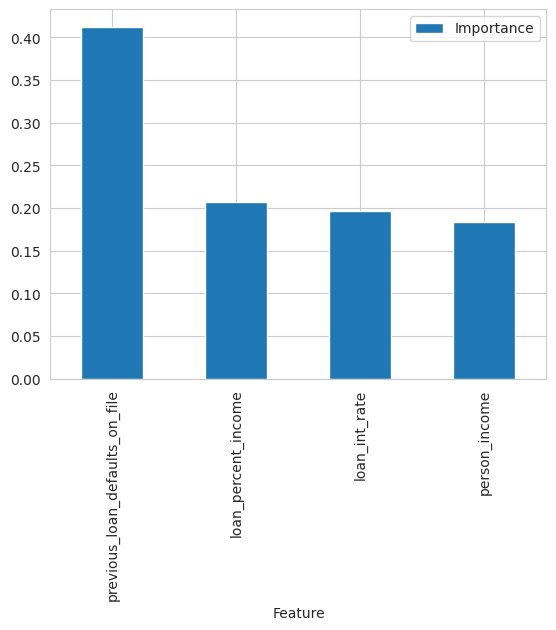

In [62]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

- Save feature importance plot.

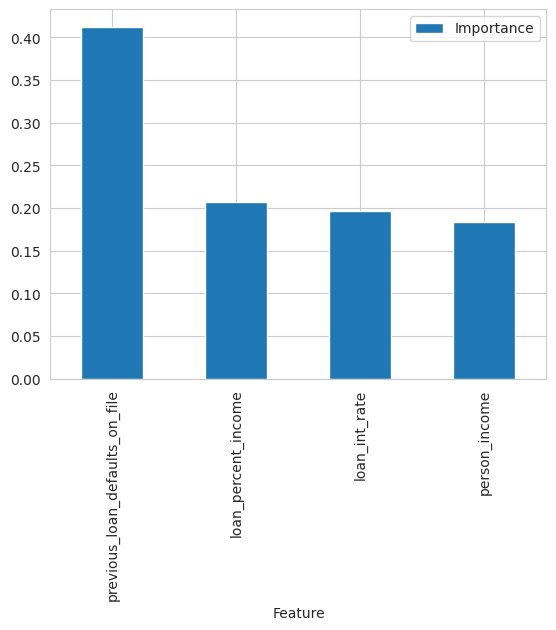

In [63]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')